In [268]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Overview
In this series I learned how the finite element method works. Very simple conceptually, and once the math is shown, implementation and even generalization to multiple dimensions is pretty convenient. Below I show how to implement 
- 1D finite element
- 1D finite volume
- 2D finite element

The simple explaination of how this works is the Fick's diffusion equation
$$\frac{dT}{dt} = \mu \frac{d^2T}{dx^2}$$
can be estimated using Taylor expansions of the left hand side (LHS) and the right hand side (RHS). $n = \text{time step}$, $j = \
text{position}$
1. LHS: $T^{n+1}_{j} = T^{n}_{j} + \Delta t \frac{dT}{dt} + \frac{\Delta t^2}{2}\frac{d^2T}{dt^2} + ...$
1. RHS (forward): $T^{n}_{j+1} = T^{n}_{j} + \Delta x \frac{dT}{dx} + \frac{\Delta x^2}{2}\frac{d^2T}{dx^2} + ...$
1. RHS (backward): $T^{n}_{j-1} = T^{n}_{j-1} - \Delta t \frac{dT}{dt} + \frac{\Delta t^2}{2}\frac{d^2T}{dt^2} + ...$
1. RHS (central = RHS-forward + RHS-backward): $T^{n}_{j+1} +  T^{n}_{j-1} = 2\cdot T^{n}_{j} + 2\cdot \frac{\Delta x^2}{2}\frac{d^2T}{dx^2} + ...$

Solving the LHS and RHS for $\frac{dT}{dt}$ in equation 1 and $\frac{d^2T}{dx^2}$ in equation 4, while truncating larger terms (calling it error) gives us an estimate of each derivative. Plugging these estimates into our Fick's diffusion equation we get
$$\frac{T^{n+1}_{j} - T^{n}_{j}}{\Delta t} = \frac{\mu}{2\Delta x^2}(T^{n}_{j+1} +  T^{n}_{j-1} - 2\cdot T^{n}_{j})$$

Solving this for $n+1$ terms on one side we get our discrete estimates for equations of change.
$$T^{n+1}_{j} = \underbrace{\frac{\mu \Delta t}{2\Delta x^2}(T^{n}_{j+1} +  T^{n}_{j-1} - 2T^{n}_{j})}_{\text{new value used to update based on surroundings}} + \underbrace{T^{n}_{j}}_{\text{old value}}$$.

---

This thing says that our next temperature value at a given point (of a one dimensional line) is the old value + some combination of surrounding points with a coefficient that depends on how big we make our steps, how big of a time step we have, and the material properties of the substance we are observing

# One dimension implementation
## Finite element

In [159]:
def FTCS_temp_sim(time_total=0.5):
    '''Given the amount of time elapsed, simulate how heat transfers through a material with the coefficient mu'''
    # Initialize variables
    mu = 0.1
    x_total = 1
    time_total = time_total
    dx = 0.05
    dt = 0.0125
    n = int(time_total/dt)
    m = int(x_total/dx)
    T = np.zeros([n,m])
    l2_error = np.zeros([n, m-1])
    T[:,m-1] = 500
    constant = (mu * dt) / (2 * dx**2)
    # Loop through a time point
    for i in range(n-1):
        # Loop through spacial discretizations
        for j in range(1,m-1):
            T[i+1,j] = constant * (T[i,j+1] + T[i,j-1] - 2*T[i,j]) + T[i,j]
            l2_error[i,j] = T[i+1,j] - T[i,j]
    l2_error = ((l2_error**2).sum(axis=1))**(1/2) / (m-2)
    # Return a fully populated space and time simulation
    return([T,l2_error])

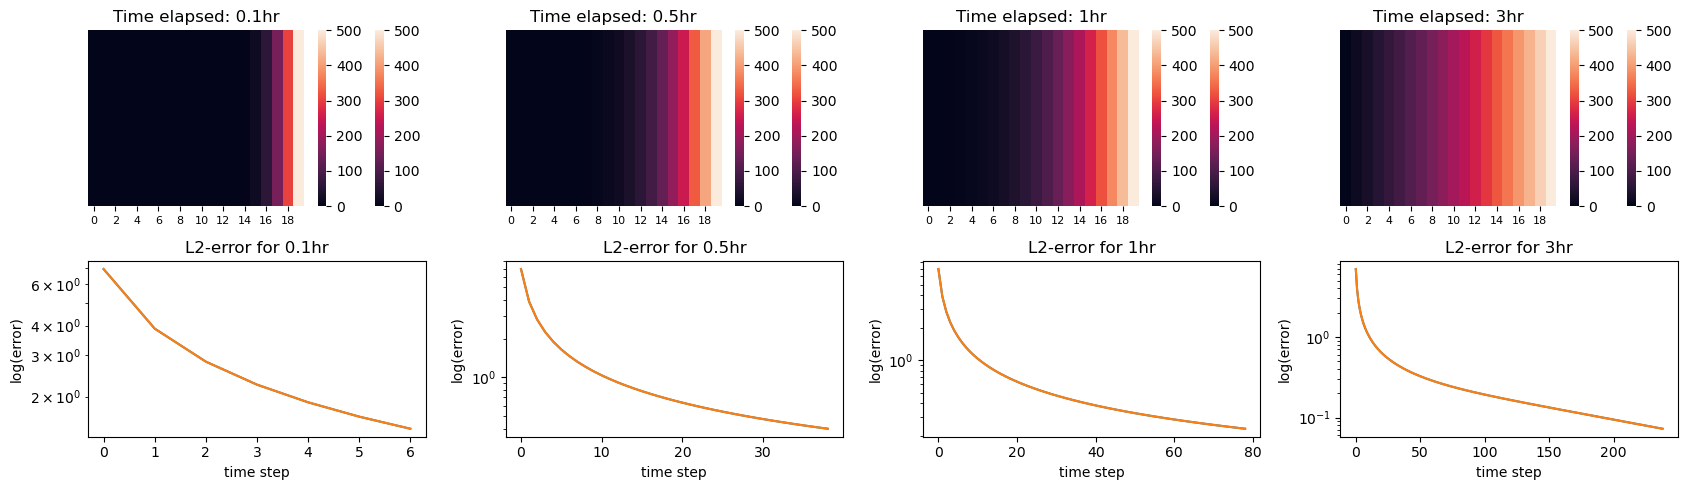

In [192]:
# Plotting the returned data for asked times
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize=(17,5))
time_elapsed = [0.1, 0.5, 1, 3]
for i in range(8):
    col = int(np.floor(i / 2))
    time = time_elapsed[col]
    temp, l2_error = FTCS_temp_sim(time_total=time)
    # Keep only the final time point of the simulation
    last_temp = temp[-1,:].reshape([20,1])
    # Heat plot formatting
    sns.heatmap(last_temp.T, yticklabels=False, ax=axes[0,col])
    axes[0,col].set_title(f"Time elapsed: {time}hr")
    axes[0,col].set_xticklabels(g.get_xticklabels(), rotation = 0, fontsize = 8)
    axes[0,col].invert_yaxis()
    # Error plot formatting
    axes[1,col].set_title(f"L2-error for {time}hr")
    axes[1,col].plot(l2_error[:-1])
    axes[1,col].set_yscale('log')
    axes[1,col].set_ylabel('log(error)')
    axes[1,col].set_xlabel('time step')
plt.tight_layout()
plt.show()

## Finite volume
This one is a bit odd. What happens here is a bit more of a mystery, but whereas finite element considers each step to be an inf small sliver, finite element considers each step, then averages the values in between. This runs into issues at the far right and left boundaries that need to be held constant per our mathematical construction of initial and boundary conditions. To remedy this situation, people create 'phantom' cells on either side that will average with the value we are modeling to produce our boundary condition.

It is basically finite element except there are two additional equations
- LHS boundary update: $\frac{T^{i+1}_{0} + T^{i+1}_{1}}{2} = \text{L.H.S. boundary}$
- RHS boundary update: $\frac{T^{i+1}_{m} + T^{i+1}_{m+1}}{2} = \text{R.H.S. boundary}$
- Update equation: $T^{n+1}_{j} = \underbrace{\frac{\mu \Delta t}{\Delta x^2}}_{\text{no div by 2 coeff}}(T^{n}_{j+1} +  T^{n}_{j-1} - 2T^{n}_{j}) + T^{n}_{j}$

In [198]:
def FiniteVol_temp_sim(time_total=0.5):
    '''Given the amount of time elapsed, simulate how heat transfers through a material with the coefficient mu'''
    # Initialize variables
    mu = 0.1
    x_total = 1
    time_total = time_total
    dx = 0.05
    dt = 0.0125
    n = int(time_total/dt)
    m = int(x_total/dx)
    T = np.zeros([n,m+1])
    l2_error = np.zeros([n, m])
    T[0,m] = 500*2 - 0 
    constant = (mu * dt) / (dx**2)
    # Loop through a time point
    for i in range(n-1):
        # Loop through spacial discretizations
        for j in range(1,m):
            T[i+1,j] = constant * (T[i,j+1] + T[i,j-1] - 2*T[i,j]) + T[i,j]
            l2_error[i,j] = T[i+1,j] - T[i,j]
        T[i+1,0] = -T[i+1,1]
        T[i+1,m] = 1000 - T[i+1,m-1]
    l2_error = ((l2_error**2).sum(axis=1))**(1/2) / (m-2)
    # Return a fully populated space and time simulation
    return([T[-1,1:m].reshape([19,1]), l2_error])

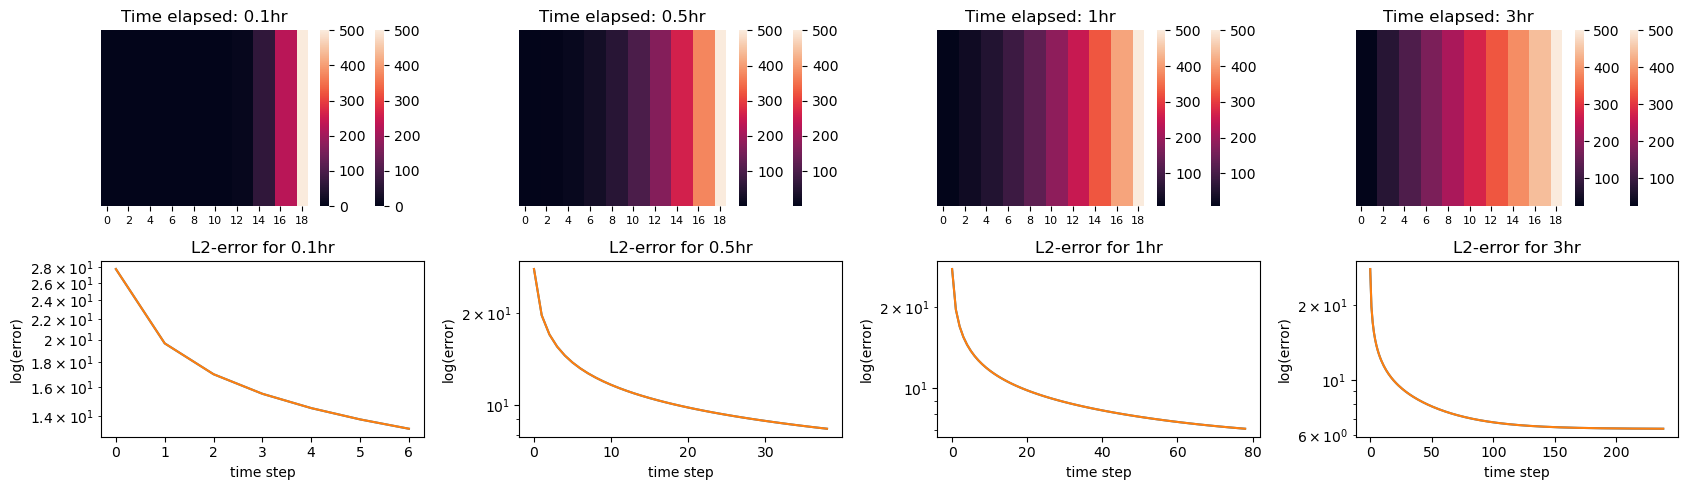

In [200]:
# Plotting the returned data for asked times
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize=(17,5))
time_elapsed = [0.1, 0.5, 1, 3]
for i in range(8):
    col = int(np.floor(i / 2))
    time = time_elapsed[col]
    temp,l2_error = FiniteVol_temp_sim(time_total=time)
    # Keep only the final time point of the simulation
    last_temp = temp
    # Heat plot formatting
    g = sns.heatmap(last_temp.T, yticklabels=False, ax=axes[0,col])
    axes[0,col].set_title(f"Time elapsed: {time}hr")
    axes[0,col].set_xticklabels(g.get_xticklabels(), rotation = 0, fontsize = 8)
    axes[0,col].invert_yaxis()
    # Error plot formatting
    axes[1,col].set_title(f"L2-error for {time}hr")
    axes[1,col].plot(l2_error[:-1])
    axes[1,col].set_yscale('log')
    axes[1,col].set_ylabel('log(error)')
    axes[1,col].set_xlabel('time step')
plt.tight_layout()
plt.show()

## Error calculations
I've been calculating error as `l2_error` by essentially summing the difference between this time step and the next predicted one, squaring and summing. The less difference, the less error apparently.

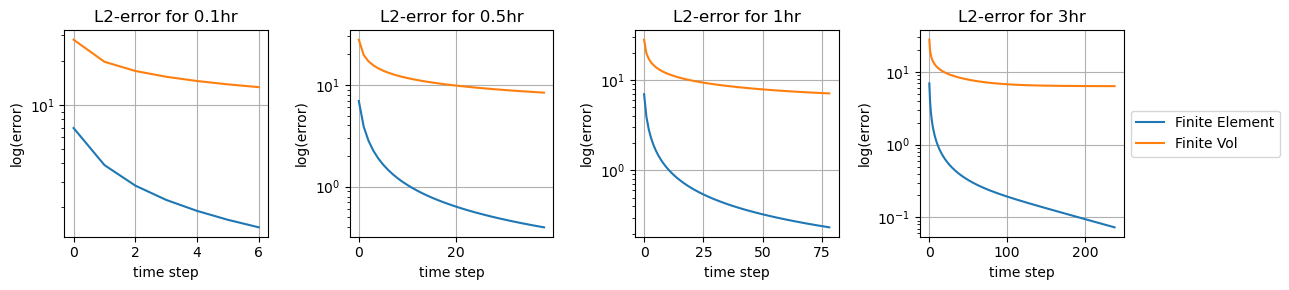

In [212]:
# Plotting the returned data for asked times
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize=(13,3))
time_elapsed = [0.1, 0.5, 1, 3]
for i in range(4):
    col = int(np.floor(i / 1))
    time = time_elapsed[col]
    temp, l2_error_FE = FTCS_temp_sim(time_total=time)
    temp, l2_error_FV = FiniteVol_temp_sim(time_total=time)
    # Error plot formatting Finite Element
    axes[col].plot(l2_error_FE[:-1], label="Finite Element")
    # Error plot formatting Finite Volume
    axes[col].plot(l2_error_FV[:-1], label="Finite Vol")
    axes[col].set_yscale('log')
    axes[col].set_ylabel('log(error)')
    axes[col].set_xlabel('time step')
    axes[col].set_title(f"L2-error for {time}hr")    
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Matthew attempt at 2 Dimension implementation
This is an interesting one. I'm not sure if I've done it correctly, but it looks like it works alright. The update rule is the same as the one dimension implementation, except now we need to consider 4 neighbor directions. 
- horizontal
- vertical
- diagonal positive slope
- diagonal negative slope

I reason that the update term for each of these neighbor directions should sum (not average) considering if I add more heat sources from different directions I expect to get hot faster. The current time point value should only be added once to not double count. The distance between horizontal and vertical blocks can stay as $\Delta x$, but for the diagonals the distance feels right to say $\frac{\Delta x}{\sqrt{2}}$ using pathagoreous theorem. Note that going up to 3 dimensions might be yet another challenge, but possible by just considering neighbors and letting the update rule expand as it has done here from 1 to 2 dimensions with more neighbors.

**One lesson** I learned trying to generalize a 1D to 2D problem is if we discretize a 1D path, do not thing the box representation we learned in class is the truth. We shouldn't consider a box with lines as boundaries. We should consider a line with points as boundaries. Points are easy to generalize compared to a line.

In [371]:
mu = 0.01
x_total = 1
time_total = 10
dx = 0.05
dt = 0.01 #0.0125
n = int(time_total/dt)
m = int(x_total/dx)
#        time, rows, columns
T = np.zeros([n,m,m])
# T[:,m-1,-5:-1] = 500
# T[:,m-1,1:5] = 500
# T[:,9,9] = 500
T[:,1:5,1:5] = 500
T[:,4:10,16] = 500
constant = (mu * dt) / (2 * dx**2)

In [374]:
# Loop through a time point
for i in range(n-1):
    # Loop through all spacial discretizations
    for j in range(0,((m-2)*(m-2))):
        row = (j // 18) + 1
        col = (j % 18) + 1
        update_term = 0
        # horizontal
        constant = (mu * dt) / (2 * dx**2)
        update_term += constant * (T[i, row,col+1] + T[i,row,col-1] - 2*T[i,row,col])
        # vertical
        update_term += constant * (T[i, row+1,col] + T[i,row-1,col] - 2*T[i,row,col])
        # diag up slope
        constant = (mu * dt) / (2 * (dx/np.sqrt(2))**2)
        update_term += constant * (T[i, row+1,col+1] + T[i,row-1,col-1] - 2*T[i,row,col])
        # diag down slope
        update_term += constant * (T[i, row+1,col-1] + T[i,row-1,col+1] - 2*T[i,row,col])
        
        # Set value
        T[i+1,row,col] = update_term + T[i,row,col]   
    # Preserve boundary conditions (otherwise they get overridden above)
    T[:,1:5,1:5] = 500
    T[:,4:10,16] = 500

<AxesSubplot:>

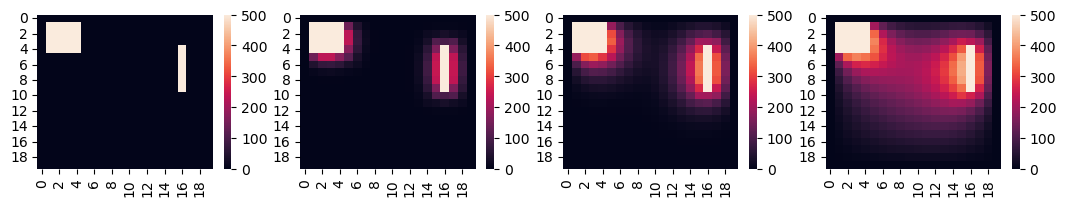

In [375]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize=(13,2))
sns.heatmap(T[0,:,:], ax=axes[0])
sns.heatmap(T[10,:,:], ax=axes[1])
sns.heatmap(T[50,:,:], ax=axes[2])
sns.heatmap(T[n-1,:,:], ax=axes[3])